In [ ]:
from torch.optim import optimizer
from pandas._libs import index
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class FacesDataset(Dataset):
  def __init__(self):
    x = np.loadtxt(('/content/drive/MyDrive/Assignment2Data/train_data.csv'), delimiter=",", dtype=(np.float32)) #specifing x as train_data and reading csv
    y = np.loadtxt(('/content/drive/MyDrive/Assignment2Data/train_target.csv'),delimiter = ",", dtype = (np.float32)) #setting targets data and reading csv
    self.x = torch.from_numpy(x)#converting to torch tensor
    self.x = self.x[:,:].reshape(16175,1,48,48) #reshaping to add chanel dimmension as well as converting the 2304 pixels into 48x48 dimmensions
    self.y = torch.from_numpy(y)#converting to torch tensor


    
  def __getitem__(self,index):
    return self.x[index], self.y[index]
  def __len__(self):
    return len(self.y)
train_data = FacesDataset() #calling faces data set and initializing

class testDataset(Dataset):
  def __init__(self):
    x = np.loadtxt(('/content/drive/MyDrive/Assignment2Data/test_data.csv'), delimiter=",", dtype=(np.float32))#specifying testing dataset
    self.x = torch.from_numpy(x)
    self.x = self.x[:,:].reshape(3965,1,48,48)#reshaping for grayscale chanel dimmension


    
  def __getitem__(self,index):
    return self.x[index]
  def __len__(self):
    return len(self.x)
test_data = testDataset() #calling test data set and intitializing



In [ ]:
emotions = ['Angry','Happy','Neutral'] # we dont use this because our predictions come out as 0,1,2


In [ ]:
from torch.nn.modules.conv import Conv2d
#conv model to process the given image data set
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3, padding=1),#1 channel input due to grayscale images
        nn.ReLU(),#computation saving
        nn.Conv2d(16,32,kernel_size=3, padding=1), #conv layers will be taking the previous layers output as their input
        nn.ReLU(),
        nn.BatchNorm2d(32), #help speed up the training as well as stabalization
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32,64, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,64, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64), #batch norm set to 64 to account for our last output
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64,64, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Dropout(0.2), #dropouts to prevent some over fitting
        nn.Conv2d(64,64, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64,64, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(64,128, kernel_size=3, stride=1,padding=1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.BatchNorm2d(128), #batchnorm to 128 to account for ouput
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128,128,kernel_size=3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Dropout(0.25), #dropouts to help prevent over fitting
        nn.Conv2d(128,128,kernel_size=3,stride =1, padding = 1),
        nn.ReLU(),
        nn.Dropout(0.25), #dropout
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),

        nn.Flatten(), #reshaping to be able to pass to next layer
        nn.Linear(128*1*1, 1024),#connecting the network
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 3)#outputting 3 for our number of emotions
)

  def forward(self,x):
    return self.net(x)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"#specifying device
print(f"Using {device} device")

Using cuda device


In [ ]:
#hyperparameters
num_classes = 3 #number of classes or possible emotions
learning_rate = 0.001
batch_size = 5
num_epoch = 20

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size,shuffle = True, num_workers = 2)#initializing train loader with shuffle
test_loader = DataLoader(dataset = test_data, batch_size = batch_size,shuffle = False, num_workers = 2)
dataiter = iter(test_loader)#iterating loader to get the shape of our inputs
images = dataiter.next()
print(type(images))
print(images.shape) 

<class 'torch.Tensor'>
torch.Size([5, 1, 48, 48])


In [ ]:
model = NN().to(device)
#input_size = input_size, num_classes = num_classes

In [ ]:
weight_decay = 1e-4 # weight decay to try to prevent over fitting to training set
criterion = nn.CrossEntropyLoss() #loss
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)#using adam as optimizer

In [ ]:
#training model
ep = 0
loss_list = []

for epoch in range(num_epoch):
  running_loss = 0
  corr = 0
  tot = 0
  ep += 1
  print("epoch: ",ep)
  model.train()#training mode
  for ind, (data,target) in enumerate(tqdm(train_loader)): #iterating through train loader
    target = target.type(torch.LongTensor)
    data = data.to(device = device)
    target = target.to(device = device)
    scores = model(data)#feeding training data into model
    #print(scores)
    loss = criterion(scores, target)#using criterion to calculate the loss function with CrossEntropy
    optimizer.zero_grad()#optimizer
    loss.backward()#back prop
    optimizer.step()#optimizer step
    running_loss += loss.item() #keeping track of loss
  train_loss = running_loss/len(train_loader)
  loss_list.append(train_loss)#appending to loss list for graphing

def check_accuracy(loader, model): #checking accuracy of training set
  correct = 0
  samples = 0
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device)
      y = y.to(device=device)
      scores = model(x)
      #print(scores)
      _, predictions = scores.max(1)
      #print(predictions)
      correct += (predictions == y).sum()
      samples += predictions.size(0)
    model.train()
    return correct/samples
accuracy = check_accuracy(train_loader,model)
print(accuracy*100)


epoch:  1


100%|██████████| 3235/3235 [00:40<00:00, 80.66it/s]


epoch:  2


100%|██████████| 3235/3235 [00:38<00:00, 83.22it/s]


epoch:  3


100%|██████████| 3235/3235 [00:39<00:00, 81.64it/s]


epoch:  4


100%|██████████| 3235/3235 [00:39<00:00, 82.84it/s]


epoch:  5


100%|██████████| 3235/3235 [00:39<00:00, 82.00it/s]


epoch:  6


100%|██████████| 3235/3235 [00:39<00:00, 81.07it/s]


epoch:  7


100%|██████████| 3235/3235 [00:39<00:00, 82.16it/s]


epoch:  8


100%|██████████| 3235/3235 [00:40<00:00, 80.67it/s]


epoch:  9


100%|██████████| 3235/3235 [00:39<00:00, 82.69it/s]


epoch:  10


100%|██████████| 3235/3235 [00:38<00:00, 83.40it/s]


epoch:  11


100%|██████████| 3235/3235 [00:39<00:00, 81.59it/s]


epoch:  12


100%|██████████| 3235/3235 [00:38<00:00, 83.35it/s]


epoch:  13


100%|██████████| 3235/3235 [00:39<00:00, 81.97it/s]


epoch:  14


100%|██████████| 3235/3235 [00:38<00:00, 83.42it/s]


epoch:  15


100%|██████████| 3235/3235 [00:39<00:00, 82.90it/s]


epoch:  16


100%|██████████| 3235/3235 [00:38<00:00, 83.23it/s]


epoch:  17


100%|██████████| 3235/3235 [00:39<00:00, 81.11it/s]


epoch:  18


100%|██████████| 3235/3235 [00:38<00:00, 84.47it/s]


epoch:  19


100%|██████████| 3235/3235 [00:38<00:00, 83.73it/s]


epoch:  20


100%|██████████| 3235/3235 [00:37<00:00, 85.87it/s]


tensor(85.2303, device='cuda:0')


In [ ]:
PATH = 'model contents'#name of model file when saved
torch.save(model, PATH)#saving model

In [ ]:
import csv
model = torch.load(PATH)#loading model
model.eval()#evaluation mode
b = []#to keep track of prediction values
count = 0
#with torch.no_grad():
for x in (test_loader): #iterating through test loader to get predictions
    x = x.to(device=device)
    score = model(x) #running inputs through model
    _, pred = score.max(1) #returning max values of the score for predictions
    #print(pred)
    new = pred.detach().cpu().tolist() #detaching to be able to append the values to b list
    for i in new:
      b.append(i)

#writing to csv
with open('submission1.csv','w',newline='')as csvfile:
  Details= ['Id','Category']
  thewriter = csv.DictWriter(csvfile, fieldnames=Details)
  thewriter.writeheader()
  i = 0
  for i in range(len(b)):
    thewriter.writerow({'Id':count,'Category':b[i]})
    count+=1
print(b)

[0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 2, 2, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 0, 2, 2, 1, 2, 0, 0, 1, 2, 0, 0, 1, 0, 2, 1, 0, 2, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 0, 1, 0, 2, 0, 2, 2, 2, 1, 0, 0, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1, 1, 2, 0, 0, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 

torch.Size([3965, 1, 48, 48])


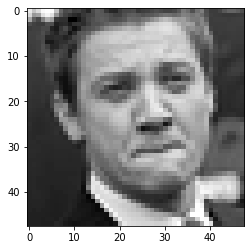

In [ ]:
X = test_data.x
print(X.shape)
y = train_data.y
plt.imshow(X[0].reshape(48,48), cmap ='gray') #printing out test pictures to verify some of the validation prediction manually

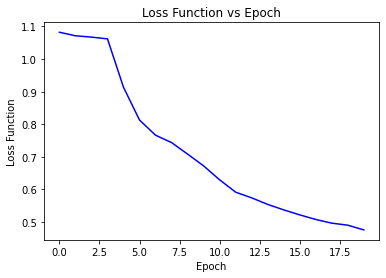

In [ ]:
plt.plot(range(num_epoch),loss_list, color = 'b', label='Training Loss')
plt.title("Loss Function vs Epoch")
plt.ylabel("Loss Function")
plt.xlabel("Epoch")
plt.show()